In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from IPython.display import display

In [2]:
BASE_DIR = os.getcwd()

gender_file = os.path.join(BASE_DIR, "data/predicted_gender.jsonl")
works_file = os.path.join(BASE_DIR, "data/works_api_url.jsonl")
author_file = os.path.join(BASE_DIR, "author_list.json") 

In [3]:
def load_jsonl(filepath):
    """Function to load a .jsonl file into a DataFrame"""
    with open(filepath, "r", encoding="utf-8") as f:
        data = [json.loads(line) for line in f]
    return pd.DataFrame(data)

In [4]:
gender_df = load_jsonl(gender_file)
works_df = load_jsonl(works_file)

In [5]:
with open(author_file, "r", encoding="utf-8") as f:
    author_data = json.load(f)
author_df = pd.DataFrame(author_data)

In [6]:
if "id" not in author_df.columns or "id" not in gender_df.columns or "id" not in works_df.columns:
    raise ValueError("One or more datasets are missing the 'id' column!")



In [7]:
merged_df = (
    author_df.merge(gender_df, on="id", how="inner")
    .merge(works_df, on="id", how="inner")
)

In [8]:
if "x_concepts" in merged_df.columns:
    merged_df["x_concepts"] = merged_df["x_concepts"].apply(lambda x: [c if isinstance(c, str) else c["display_name"] for c in x])
    concepts_df = merged_df.explode("x_concepts")
else:
    raise ValueError("Column 'x_concepts' not found in merged dataset!")


In [9]:
stats_by_field = (
    concepts_df.groupby(["x_concepts", "predicted_gender"]).agg({"works_count": "mean"})
                        .reset_index()
)

In [10]:
stats_by_field["works_count"] = stats_by_field["works_count"].fillna(0)



In [11]:
top_n = 20
top_fields = stats_by_field.groupby("x_concepts")["works_count"].mean().nlargest(top_n).index
filtered_df = stats_by_field[stats_by_field["x_concepts"].isin(top_fields)]
pivot_df = filtered_df.pivot(index="x_concepts", columns = "predicted_gender", values="works_count").fillna(0)
pivot_df = pivot_df.loc[(pivot_df !=0).any(axis=1)]

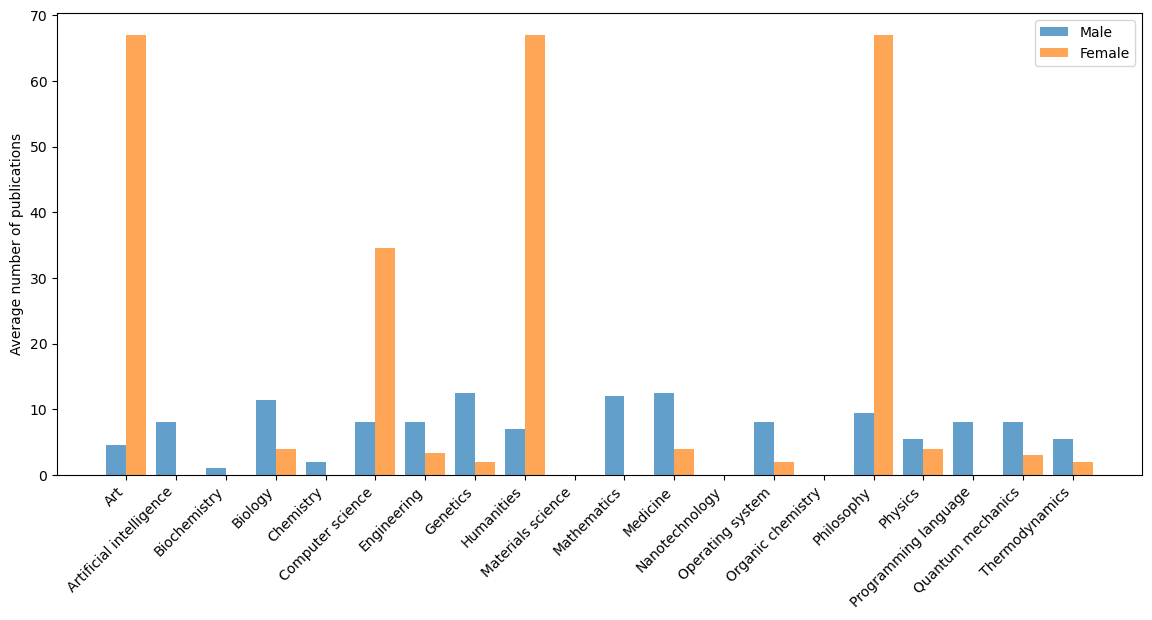

In [12]:
import numpy as np

plt.figure(figsize=(14, 6))
width = 0.4
x = np.arange(len(pivot_df))

plt.bar(x - width/2, pivot_df.get("Male", np.zeros(len(pivot_df))), width=width, label="Male", alpha=0.7)
plt.bar(x + width/2, pivot_df.get("Female", np.zeros(len(pivot_df))), width=width, label="Female", alpha=0.7)

plt.xticks(x, pivot_df.index, rotation=45, ha="right")
plt.ylabel("Average number of publications")
plt.legend()
plt.show()

In [13]:
for field in top_fields:
    male_count = pivot_df.loc[field, "Male"] if "Male" in pivot_df.columns else 0
    female_count = pivot_df.loc[field, "Female"] if "Female" in pivot_df.columns else 0
    print(f"{field} - Male: {male_count}, Female: {female_count}")

Nanotechnology - Male: 0.0, Female: 0.0
Artificial intelligence - Male: 8.0, Female: 0.0
Materials science - Male: 0.0, Female: 0.0
Organic chemistry - Male: 0.0, Female: 0.0
Biochemistry - Male: 1.0, Female: 0.0
Programming language - Male: 8.0, Female: 0.0
Thermodynamics - Male: 5.5, Female: 2.0
Chemistry - Male: 2.0, Female: 0.0
Computer science - Male: 8.0, Female: 34.5
Genetics - Male: 12.5, Female: 2.0
Quantum mechanics - Male: 8.0, Female: 3.0
Mathematics - Male: 12.0, Female: 0.0
Operating system - Male: 8.0, Female: 2.0
Physics - Male: 5.5, Female: 4.0
Engineering - Male: 8.0, Female: 3.3333333333333335
Humanities - Male: 7.0, Female: 67.0
Medicine - Male: 12.5, Female: 4.0
Biology - Male: 11.4, Female: 4.0
Philosophy - Male: 9.5, Female: 67.0
Art - Male: 4.5, Female: 67.0


In [14]:
import seaborn as sns
STEM_fields = {"Computer Science", "Biology", "Medicine", "Mathematics", "Physics", "Engineering", "Genetics", "Quantum Mechanics"}
HSS_fields = {"Philosophy", "Sociology", "Psychology", "History", "Linguistics", "Political Science", "Education", "Anthropology"}

if "x_concepts" not in stats_by_field.columns:
    raise ValueError("Column 'x_concepts' not found in stats_by_field")
stats_by_field["field_category"] = stats_by_field["x_concepts"].apply(
    lambda x: "STEM" if x in STEM_fields else "HSS" if x in HSS_fields else "Other"
)

category_stats = stats_by_field.groupby(["field_category", "predicted_gender"]).agg(
    avg_works_count=("works_count", "mean")
).reset_index()

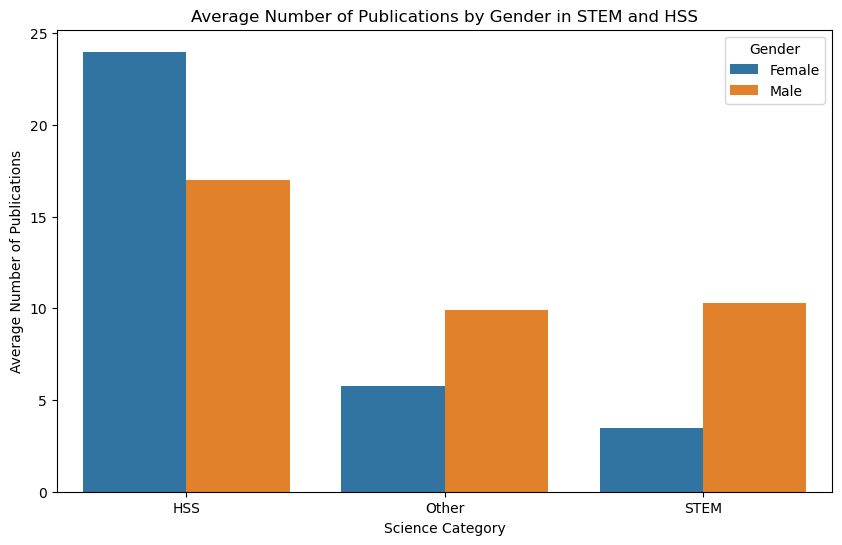

In [15]:
category_stats_filtered = category_stats[category_stats["predicted_gender"].isin(["Male", "Female"])]

plt.figure(figsize=(10, 6))
sns.barplot(data=category_stats_filtered, x="field_category", y="avg_works_count", hue="predicted_gender")
plt.title("Average Number of Publications by Gender in STEM and HSS")
plt.ylabel("Average Number of Publications")
plt.xlabel("Science Category")
plt.legend(title="Gender")
plt.show()